### 一. 简介

Bagging的思路很简单，对大小为$n$的样本集进行$n$次重采样得到一个新的样本集，在新样本集上训练一个基学习器，该过程执行$m$，最后对这$m$个基学习器做组合即得到最后的强学习器：  
![avatar](./source/10_bagging.png)
### 二.代码实现：分类

In [1]:
import os
os.chdir('../')
from ml_models import utils
import copy
import numpy as np
from ml_models.tree import CARTClassifier

"""
bagging分类实现，封装到ml_models.ensemble
"""

class BaggingClassifier(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            # 默认使用决策树
            self.base_estimator = CARTClassifier()
        # 同质分类器
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质分类器
        else:
            self.n_estimators = len(self.base_estimator)

    def fit(self, x, y):
        # TODO:并行优化
        n_sample = x.shape[0]
        for estimator in self.base_estimator:
            # 重采样训练集
            indices = np.random.choice(n_sample, n_sample, replace=True)
            x_bootstrap = x[indices]
            y_bootstrap = y[indices]
            estimator.fit(x_bootstrap, y_bootstrap)

    def predict_proba(self, x):
        # TODO:并行优化
        probas = []
        for estimator in self.base_estimator:
            probas.append(estimator.predict_proba(x))

        return np.mean(probas, axis=0)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

In [2]:
#造伪数据
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=100, n_features=2, n_classes=2, n_informative=1, n_redundant=0,
                                   n_repeated=0, n_clusters_per_class=1, class_sep=.5,random_state=21)

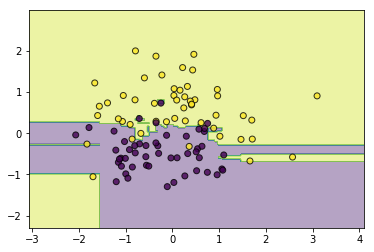

In [3]:
#同质
classifier = BaggingClassifier()
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

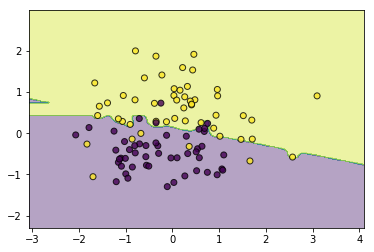

In [4]:
#异质
from ml_models.linear_model import LogisticRegression
from ml_models.svm import SVC
classifier = BaggingClassifier(base_estimator=[LogisticRegression(),SVC(kernel='rbf',C=5.0),CARTClassifier(max_depth=2)])
classifier.fit(data, target)
utils.plot_decision_function(data, target, classifier)

### 三.代码实现：回归

In [5]:
from ml_models.tree import CARTRegressor

"""
bagging回归实现，封装到ml_models.ensemble
"""

class BaggingRegressor(object):
    def __init__(self, base_estimator=None, n_estimators=10):
        """
        :param base_estimator: 基学习器，允许异质；异质的情况下使用列表传入比如[estimator1,estimator2,...,estimator10],这时n_estimators会失效；
                                同质的情况，单个estimator会被copy成n_estimators份
        :param n_estimators: 基学习器迭代数量
        """
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        if self.base_estimator is None:
            # 默认使用决策树
            self.base_estimator = CARTRegressor()
        # 同质
        if type(base_estimator) != list:
            estimator = self.base_estimator
            self.base_estimator = [copy.deepcopy(estimator) for _ in range(0, self.n_estimators)]
        # 异质
        else:
            self.n_estimators = len(self.base_estimator)

    def fit(self, x, y):
        # TODO:并行优化
        n_sample = x.shape[0]
        for estimator in self.base_estimator:
            # 重采样训练集
            indices = np.random.choice(n_sample, n_sample, replace=True)
            x_bootstrap = x[indices]
            y_bootstrap = y[indices]
            estimator.fit(x_bootstrap, y_bootstrap)

    def predict(self, x):
        # TODO:并行优化
        preds = []
        for estimator in self.base_estimator:
            preds.append(estimator.predict(x))

        return np.mean(preds, axis=0)

In [6]:
#构造数据
data = np.linspace(1, 10, num=100)
target1 = 3*data[:50] + np.random.random(size=50)*3#添加噪声
target2 = 3*data[50:] + np.random.random(size=50)*10#添加噪声
target=np.concatenate([target1,target2])
data = data.reshape((-1, 1))

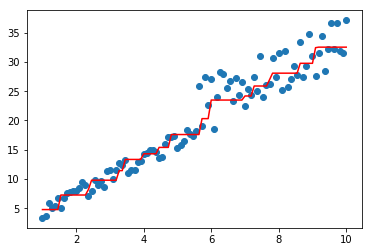

In [7]:
#同质
import matplotlib.pyplot as plt
model=BaggingRegressor(base_estimator=CARTRegressor(),n_estimators=2)
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

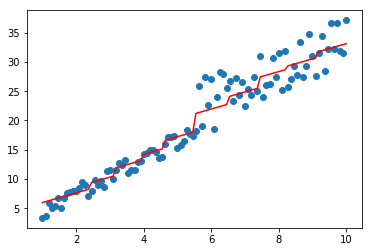

In [8]:
#异质
from ml_models.linear_model import LinearRegression
model=BaggingRegressor(base_estimator=[LinearRegression(),CARTRegressor()])
model.fit(data,target)
plt.scatter(data, target)
plt.plot(data, model.predict(data), color='r')

### 四.问题讨论

下面简单推导一下，重采样会有多少比例的样本未能被抽到，已知道总样本量为$m$，那么每轮任一样本未被抽中的概率为$\frac{m-1}{m}$，所以$m$轮未被抽中的概率为$(\frac{m-1}{m})^m$，对$m$取极限可得：  

$$
\lim_{m\rightarrow \infty}(1-\frac{1}{m})^m=\frac{1}{e}\approx0.368
$$  

简单验证一下：  

In [9]:
ratios=[]
#最小样本量
min_sample=100
#最大样本量
max_sample=1000
#每次实验重复次数
repeat_num=100
for n_sample in range(min_sample,max_sample):
    tmp=[]
    for _ in range(0,repeat_num):
        new_indices=np.random.choice(n_sample,n_sample,replace=True)
        tmp.append(1-len(set(new_indices))/n_sample)
    ratios.append(np.mean(tmp))

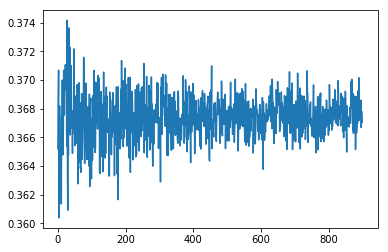

In [10]:
plt.plot(ratios)